# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache, Shrec17DatasetTF

## 0.2 Define parameters

In [4]:
Nside = 64
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
download = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
#train_dataset = Shrec17DatasetCache(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)


Better to keep validation and testing set in RAM, but not always possible

In [7]:
val_dataset = Shrec17DatasetCache(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, augmentation=1, nfile=None)

Try do make a tensorflow dataset object

In [8]:
train_TFDataset = Shrec17DatasetTF(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

In [9]:
#dataset = train_TFDataset.get_tf_dataset(32)

In [12]:
# import time
# import tensorflow as tf

# #dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
# t_start = time.time()
# data_next = dataset.make_one_shot_iterator().get_next()
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# steps = train_TFDataset.N // 32 + 1
# with tf.Session(config=config) as sess:
#     sess.run(tf.global_variables_initializer())
#     try:
#         for i in range(steps):
#             out = sess.run(data_next)
#     except tf.errors.OutOfRangeError:
#         print("Done") # Never reach this as will iterate on infinite sets
# t_end = time.time()
# print(str(t_end-t_start)+" s")

# # t_start = time.time()
# # data_iter = train_dataset.iter(32)
# # steps = int(train_dataset.N / 32)
# # for i in range(steps):
# #     next(data_iter)
# #     #feed_dict = {self.ph_data: batch_data, self.ph_labels: batch_labels, self.ph_training: True}
# # t_end = time.time()
# # print(str(t_end-t_start)+" s")

23.56311297416687 s


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [9]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
#ids_train = train_dataset.ids
print('number of class:',nclass,'\nnumber of elements:',num_elem)#,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364


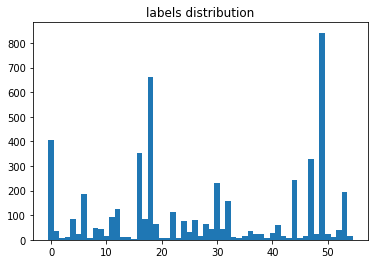

In [10]:
# x_val, labels_val, ids_val = val_dataset.return_data(train=False)

In [10]:
nfeat = 6#x_val.shape[-1]

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [12]:
# #training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
# #training = LabeledDataset(x_train, labels_train)
# validation = LabeledDataset(x_val, labels_val)

In [11]:
EXP_NAME = 'shrec17_best_5K_cache_{}aug_{}sides{}'.format(augmentation, Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = "shrec17_best_5K_cache_3aug_32sides_CNN"
#EXP_NAME = 'essai_TFDataset'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [12]:
params = hyperparameters.get_params_shrec17_optim(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
model = models.deepsphere(**params)

#sides: [64, 32, 16, 8, 4, 2, 2]
#pixels: [49152, 12288, 3072, 768, 192, 48, 48]
#samples per batch: 32
=> #pixels per batch (input): 1,572,864
=> #pixels for training (input): 154,160,332,800
Learning rate will start at 1.0e-02 and finish at 1.0e-02.
NN architecture
  input: M_0 = 49152
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 49152 * 16 / 4 = 196608
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 12288 * 32 / 4 = 98304
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 3072 * 64 / 4 = 49152
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 768 * 128 / 4 = 24576
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5:

In [19]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [13]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
logits/weights:0
the number of parameters in the model is: 232,656


In [21]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

step 490 / 98012 (epoch 0.50 / 100):
  learning_rate = 1.00e-02, training loss = 1.76e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 68.19 (3500 / 5133), f1 (weighted): 64.42, loss: 1.38e+00
  CPU time: 275s, wall time: 174s, perf_time_load: 0.26s, perf_time: 0.26s
step 980 / 98012 (epoch 1.00 / 100):
  learning_rate = 1.00e-02, training loss = 1.68e+00
  validation accuracy: 70.39 (3613 / 5133), f1 (weighted): 67.63, loss: 1.31e+00
  CPU time: 550s, wall time: 346s, perf_time_load: 0.26s, perf_time: 0.26s
step 1470 / 98012 (epoch 1.50 / 100):
  learning_rate = 1.00e-02, training loss = 8.28e-01
  validation accuracy: 74.21 (3809 / 5133), f1 (weighted): 71.91, loss: 1.16e+00
  CPU time: 829s, wall time: 517s, perf_time_load: 0.26s, perf_time: 0.26s
step 1960 / 98012 (epoch 2.00 / 100):
  learning_rate = 1.00e-02, training loss = 9.76e-01
  validation accuracy: 74.01 (3799 / 5133), f1 (weighted): 71.86, loss: 1.10e+00
  CPU time: 1112s, wall time: 688s, perf_time_load: 0.26s, perf_time: 0.26s
step 2450 / 98012 (epoch 2.50 / 100):
  learning_rate = 1.00e-02, training loss = 6.09e-01
  validation

  validation accuracy: 80.56 (4135 / 5133), f1 (weighted): 79.22, loss: 9.22e-01
  CPU time: 9300s, wall time: 5834s, perf_time_load: 0.26s, perf_time: 0.26s
step 17150 / 98012 (epoch 17.50 / 100):
  learning_rate = 1.00e-02, training loss = 4.41e-01
  validation accuracy: 82.02 (4210 / 5133), f1 (weighted): 81.17, loss: 8.52e-01
  CPU time: 9558s, wall time: 6004s, perf_time_load: 0.26s, perf_time: 0.26s
step 17640 / 98012 (epoch 18.00 / 100):
  learning_rate = 1.00e-02, training loss = 4.98e-01
  validation accuracy: 81.28 (4172 / 5133), f1 (weighted): 80.45, loss: 8.81e-01
  CPU time: 9818s, wall time: 6175s, perf_time_load: 0.26s, perf_time: 0.26s
step 18130 / 98012 (epoch 18.50 / 100):
  learning_rate = 1.00e-02, training loss = 3.67e-01
  validation accuracy: 81.96 (4207 / 5133), f1 (weighted): 81.24, loss: 8.49e-01
  CPU time: 10092s, wall time: 6347s, perf_time_load: 0.26s, perf_time: 0.26s
step 18620 / 98012 (epoch 19.00 / 100):
  learning_rate = 1.00e-02, training loss = 4.72

step 32830 / 98012 (epoch 33.50 / 100):
  learning_rate = 1.00e-02, training loss = 3.39e-01
  validation accuracy: 81.36 (4176 / 5133), f1 (weighted): 80.39, loss: 9.12e-01
  CPU time: 18317s, wall time: 11507s, perf_time_load: 0.26s, perf_time: 0.26s
step 33320 / 98012 (epoch 34.00 / 100):
  learning_rate = 1.00e-02, training loss = 2.83e-01
  validation accuracy: 81.88 (4203 / 5133), f1 (weighted): 81.03, loss: 9.32e-01
  CPU time: 18589s, wall time: 11679s, perf_time_load: 0.26s, perf_time: 0.26s
step 33810 / 98012 (epoch 34.50 / 100):
  learning_rate = 1.00e-02, training loss = 2.54e-01
  validation accuracy: 81.38 (4177 / 5133), f1 (weighted): 80.63, loss: 9.46e-01
  CPU time: 18862s, wall time: 11851s, perf_time_load: 0.26s, perf_time: 0.26s
step 34300 / 98012 (epoch 35.00 / 100):
  learning_rate = 1.00e-02, training loss = 2.84e-01
  validation accuracy: 81.82 (4200 / 5133), f1 (weighted): 81.48, loss: 9.12e-01
  CPU time: 19136s, wall time: 12023s, perf_time_load: 0.26s, perf_

step 49000 / 98012 (epoch 49.99 / 100):
  learning_rate = 1.00e-02, training loss = 4.51e-01
  validation accuracy: 81.57 (4187 / 5133), f1 (weighted): 81.25, loss: 9.72e-01
  CPU time: 27330s, wall time: 17185s, perf_time_load: 0.26s, perf_time: 0.26s
step 49490 / 98012 (epoch 50.49 / 100):
  learning_rate = 1.00e-02, training loss = 3.41e-01
  validation accuracy: 81.14 (4165 / 5133), f1 (weighted): 80.46, loss: 9.91e-01
  CPU time: 27600s, wall time: 17357s, perf_time_load: 0.26s, perf_time: 0.26s
step 49980 / 98012 (epoch 50.99 / 100):
  learning_rate = 1.00e-02, training loss = 3.71e-01
  validation accuracy: 80.85 (4150 / 5133), f1 (weighted): 80.76, loss: 9.66e-01
  CPU time: 27873s, wall time: 17529s, perf_time_load: 0.26s, perf_time: 0.26s
step 50470 / 98012 (epoch 51.49 / 100):
  learning_rate = 1.00e-02, training loss = 3.46e-01
  validation accuracy: 81.10 (4163 / 5133), f1 (weighted): 80.71, loss: 9.67e-01
  CPU time: 28144s, wall time: 17701s, perf_time_load: 0.26s, perf_

step 65170 / 98012 (epoch 66.49 / 100):
  learning_rate = 1.00e-02, training loss = 2.74e-01
  validation accuracy: 80.81 (4148 / 5133), f1 (weighted): 80.45, loss: 1.01e+00
  CPU time: 36987s, wall time: 22921s, perf_time_load: 0.26s, perf_time: 0.26s
step 65660 / 98012 (epoch 66.99 / 100):
  learning_rate = 1.00e-02, training loss = 3.91e-01
  validation accuracy: 81.06 (4161 / 5133), f1 (weighted): 80.46, loss: 1.04e+00
  CPU time: 37288s, wall time: 23095s, perf_time_load: 0.26s, perf_time: 0.26s
step 66150 / 98012 (epoch 67.49 / 100):
  learning_rate = 1.00e-02, training loss = 4.31e-01
  validation accuracy: 80.77 (4146 / 5133), f1 (weighted): 80.05, loss: 1.01e+00
  CPU time: 37586s, wall time: 23270s, perf_time_load: 0.26s, perf_time: 0.26s
step 66640 / 98012 (epoch 67.99 / 100):
  learning_rate = 1.00e-02, training loss = 2.40e-01
  validation accuracy: 80.46 (4130 / 5133), f1 (weighted): 80.16, loss: 1.00e+00
  CPU time: 37884s, wall time: 23444s, perf_time_load: 0.26s, perf_

step 81340 / 98012 (epoch 82.99 / 100):
  learning_rate = 1.00e-02, training loss = 4.93e-01
  validation accuracy: 81.28 (4172 / 5133), f1 (weighted): 80.74, loss: 9.99e-01
  CPU time: 46901s, wall time: 28682s, perf_time_load: 0.26s, perf_time: 0.26s
step 81830 / 98012 (epoch 83.49 / 100):
  learning_rate = 1.00e-02, training loss = 3.94e-01
  validation accuracy: 79.60 (4086 / 5133), f1 (weighted): 78.83, loss: 1.11e+00
  CPU time: 47201s, wall time: 28856s, perf_time_load: 0.26s, perf_time: 0.26s
step 82320 / 98012 (epoch 83.99 / 100):
  learning_rate = 1.00e-02, training loss = 3.11e-01
  validation accuracy: 80.85 (4150 / 5133), f1 (weighted): 79.96, loss: 1.03e+00
  CPU time: 47500s, wall time: 29031s, perf_time_load: 0.26s, perf_time: 0.26s
step 82810 / 98012 (epoch 84.49 / 100):
  learning_rate = 1.00e-02, training loss = 5.05e-01
  validation accuracy: 80.89 (4152 / 5133), f1 (weighted): 80.55, loss: 1.02e+00
  CPU time: 47801s, wall time: 29206s, perf_time_load: 0.26s, perf_

step 97510 / 98012 (epoch 99.49 / 100):
  learning_rate = 1.00e-02, training loss = 2.71e-01
  validation accuracy: 80.99 (4157 / 5133), f1 (weighted): 80.71, loss: 1.03e+00
  CPU time: 56818s, wall time: 34444s, perf_time_load: 0.26s, perf_time: 0.26s
step 98000 / 98012 (epoch 99.99 / 100):
  learning_rate = 1.00e-02, training loss = 3.21e-01
  validation accuracy: 80.44 (4129 / 5133), f1 (weighted): 79.51, loss: 1.06e+00
  CPU time: 57118s, wall time: 34619s, perf_time_load: 0.26s, perf_time: 0.26s
step 98012 / 98012 (epoch 100.00 / 100):
  learning_rate = 1.00e-02, training loss = 3.24e-01
  validation accuracy: 80.69 (4142 / 5133), f1 (weighted): 80.12, loss: 1.07e+00
  CPU time: 57173s, wall time: 34668s, perf_time_load: 0.26s, perf_time: 0.26s
validation accuracy: best = 82.56, mean = 80.45
time per batch: mean = 0.26, var = 0.00%


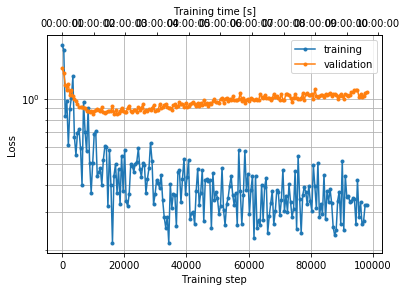

In [22]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [16]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_nsides_300epoch_reg_32sides_CNN/model-294037


('accuracy: 96.53 (30277 / 31364), f1 (weighted): 96.54, loss: 1.16e-01\nCPU time: 275s, wall time: 257s',
 96.53424308123964,
 96.54157073077505,
 0.115866209483545)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [14]:
# model.evaluate(x_val, labels_val)
model.evaluate(val_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN/model-98012


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 80.69 (4142 / 5133), f1 (weighted): 80.12, loss: 1.07e+00\nCPU time: 55s, wall time: 52s',
 80.69355152932009,
 80.11855984053359,
 1.071748793717367)

In [15]:
# probabilities = model.probs(x_val, nclass)
probabilities, _ = model.probs(val_dataset, nclass, cache=True)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = probabilities.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN/model-98012


In [16]:
ids_val = val_dataset.get_ids()

In [ ]:
#predictions = predictions.astype(np.int)

In [20]:
from SHREC17.load_shrec import shrec_output

In [24]:
shrec_output(probabilities, ids_val, datapath, 'results/val_perturbed')

In [25]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_aug/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [26]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

10265it [00:52, 194.51it/s]


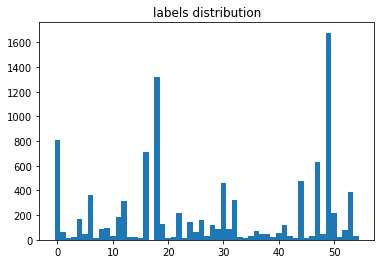

In [27]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [28]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN/model-98012


('accuracy: 75.99 (7800 / 10265), f1 (weighted): 76.07, loss: 1.24e+00\nCPU time: 102s, wall time: 96s',
 75.98636142230882,
 76.07329845432768,
 1.2386591787287158)

In [ ]:
#predictions = model.predict(x_test)

In [29]:
probabilities = model.probs(x_test, nclass)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = repeat.mean(axis=1)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_best_5K_cache_1aug_64sides_CNN/model-98012


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [30]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_aug/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_aug/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

In [31]:
shrec_output(probabilities, ids_test, datapath, 'results/test_perturbed')

Why not working?

In [46]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

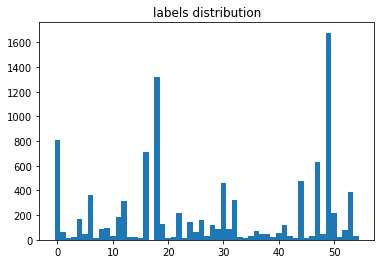

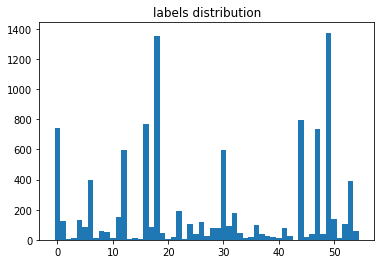

In [47]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)